In [1]:
import stereo as st
import numpy as np
import pandas as pd
import seaborn as sns
import os
import diopy
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable  # 正确的导入路径
from matplotlib.colors import LinearSegmentedColormap

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Meta in cell filter

In [9]:
import scanpy as sc
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.strtree import STRtree
from tqdm import tqdm

# --- 1. Load AnnData and meta information ---
print("Loading spatial data and metadata...")
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06050D2_after_preprocess_Final.h5ad')
meta = pd.read_csv('/data2/zhanxiaojuan/RA/new_XCR/01.results/P1_1537_1/03.raw_meta/P1_1537_1_read_2.fixed.fq.gz.meta.gz')

# --- 2. Add cellID and bin info to AnnData ---
adata.obs['cellID'] = adata.obs.index.astype(str)
adata.obs['bin50_x'] = adata.obs['x']//50*50
adata.obs['bin50_y'] = adata.obs['y']//50*50

# --- 3. Prepare cell border vertices ---
# Unroll border array to dataframe
border_array = adata.obsm['cell_border'].reshape(-1, adata.obsm['cell_border'].shape[-1])
df_border = pd.DataFrame(border_array)
df_border['cellID'] = df_border.index // 32
df_border['cellID'] = df_border['cellID'].astype(str)
df_border.rename(columns={0: 'x', 1: 'y'}, inplace=True)

# Remove boundary fill values (e.g., 32767)
df_border = df_border[(df_border['x'] != 32767) & (df_border['y'] != 32767)]

# Add cell spatial offset
df_border = pd.merge(df_border, adata.obs[['x', 'y', 'cellID']], on='cellID', how='left')
df_border['x'] = df_border['x_x'] + df_border['x_y']
df_border['y'] = df_border['y_x'] + df_border['y_y']
df_cellborder = df_border[['cellID', 'x', 'y']]

# --- 4. Collect unique coordinate points from meta ---
XCR_cor = meta[['x', 'y']].drop_duplicates(subset=['x', 'y'])

# --- 5. Construct polygons for each cellID ---
print("Building polygons...")
polygons = df_cellborder.groupby('cellID').apply(
    lambda group: Polygon(zip(group['x'], group['y']))
).reset_index(name='polygon')

# --- 6. Build a spatial index (using shapely STRtree) ---
print("Building spatial index...")
spatial_index = STRtree(polygons['polygon'])

# --- 7. Prepare query points ---
XCR_cor['point'] = XCR_cor.apply(lambda row: Point(row['x'], row['y']), axis=1)

# --- 8. Find which cellID a (x, y) coordinate belongs to ---
def find_cellID(point, polygons_df, spatial_idx):
    # Quickly filter polygons using STRtree, then check each for intersection
    match_idxs = list(spatial_idx.query(point))
    for idx in match_idxs:
        polygon_row = polygons_df.iloc[idx]
        if polygon_row['polygon'].intersects(point):
            return polygon_row['cellID']
    return None

def assign_cellIDs(df_points, polygons_df, spatial_idx):
    tqdm.pandas(desc="Assigning cellIDs")
    df_points['cellID'] = df_points['point'].progress_apply(lambda pt: find_cellID(pt, polygons_df, spatial_idx))
    return df_points

# --- 9. Assign cellIDs to all meta points ---
print("Assigning cellIDs to meta coordinates...")
df2_with_cellid = assign_cellIDs(XCR_cor.copy(), polygons, spatial_index)

# --- 10. Merge cellID back to meta and save ---
print("Merging with original meta and saving output...")
cell = pd.merge(meta, df2_with_cellid[~df2_with_cellid['cellID'].isna()][['x', 'y', 'cellID']], on=['x', 'y'], how='inner')
cell.to_csv('P1_1537_1_read_2.fixed.fq.gz.meta_with_cellID.csv.gz', sep='\t', index=False, compression='gzip')
print("Finished: CSV with cellID is saved.")


Loading spatial data and metadata...
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Building polygons...
Building spatial index...
Assigning cellIDs to meta coordinates...


Assigning cellIDs: 100%|██████████| 1590690/1590690 [01:28<00:00, 17981.79it/s]


Merging with original meta and saving output...
Finished: CSV with cellID is saved.


# XCR filter

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np

# ===============================
# Parameters and data import
# ===============================
TRA_MIN_READS       = 1
TRB_MIN_READS       = 1
TCR_FILTER_READS    = 5
IGH_MIN_READS       = 1
IGKL_MIN_READS      = 1
BCR_XCR_MIN_READS   = 5
FINAL_COL_SUFFIX    = "15"
WORKING_SUFFIX      = "XCR"
READ_LENGTH         = 130

# Load meta and AnnData objects (adjust paths as needed)
meta = pd.read_csv('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/1.23_combind/merged_meta_tsv.gz', sep='\t')

adata = sc.read_h5ad('/data2/zhanxiaojuan/RA/new_XCR/01.results/P1_1537_1/04.processed_meta/P1_1537_1_read_2.fixed.fq.gz.meta.preprocessed.h5ad')
# Optionally: Drop unused AnnData columns
del_cols = ['TRAcdr3aa', 'TRBcdr3aa', 'mutation_percent', 'CSR', 'IGK/Lcdr3aa', 'IGKorIGL', 'IGHcdr3aa','classes_meta', 'classes_stereo']
adata.obs = adata.obs.drop(del_cols, axis=1, errors='ignore')

adata.obs.index = adata.obs.index.astype(str)
# ===============================
# General filtering helper
# ===============================
def filter_by_readcount_and_function(df, min_reads=4, readid_col='readId'):
    counts = df.groupby('cid_umi')[readid_col].nunique()
    valid = counts[counts >= min_reads].index
    df = df[df['cid_umi'].isin(valid)]
    df = df[df['functional'] == 'Functional']
    return df

# ===============================
# TCR CDR3aa extraction: double voting
# ===============================
def extract_best_cdr3aa(df, chain_letter="A", cdr3_col="junction_aa", umi_col="cid_umi", cellid_col="cellID"):
    # First UMI-level voting
    unique_counts = df.groupby(umi_col)[cdr3_col].nunique().reset_index()
    multiple_cdr3aa = unique_counts[unique_counts[cdr3_col] > 1]
    unique_cdr3aa = unique_counts[unique_counts[cdr3_col] == 1]
    retrievable_umi = multiple_cdr3aa[multiple_cdr3aa[cdr3_col] <= 10][umi_col]
    retrievable = df[df[umi_col].isin(retrievable_umi)]
    if retrievable.shape[0] > 0:
        cdr3aa_counts = retrievable.groupby([umi_col, cdr3_col]).size().reset_index(name="count")
        voted_cdr3aa = cdr3aa_counts.loc[cdr3aa_counts.groupby(umi_col)["count"].idxmax()]
    else:
        voted_cdr3aa = pd.DataFrame(columns=[umi_col, cdr3_col, "count"])
    df1 = pd.concat([
        df[df[umi_col].isin(unique_cdr3aa[umi_col].unique())],
        df[df[umi_col].isin(voted_cdr3aa[umi_col].unique())]
    ], ignore_index=True)
    # Next cellID-level voting
    unique_counts = df1.groupby(cellid_col)[cdr3_col].nunique().reset_index()
    multiple_cdr3aa = unique_counts[unique_counts[cdr3_col] > 1]
    unique_cdr3aa = unique_counts[unique_counts[cdr3_col] == 1]
    retrievable_id = multiple_cdr3aa[multiple_cdr3aa[cdr3_col] <= 10][cellid_col]
    retrievable = df1[df1[cellid_col].isin(retrievable_id)]
    if retrievable.shape[0] > 0:
        cdr3aa_counts = retrievable.groupby([cellid_col, cdr3_col]).size().reset_index(name="count")
        voted_cdr3aa = cdr3aa_counts.loc[cdr3aa_counts.groupby(cellid_col)["count"].idxmax()]
    else:
        voted_cdr3aa = pd.DataFrame(columns=[cellid_col, cdr3_col, "count"])
    result = df1[df1[cellid_col].isin(unique_cdr3aa[cellid_col])][[cellid_col, cdr3_col]].drop_duplicates(subset=[cellid_col, cdr3_col])
    result = pd.concat([result, voted_cdr3aa[[cellid_col, cdr3_col]]], ignore_index=True)
    out_col = f"TR{chain_letter}cdr3aa"
    result.rename(columns={cdr3_col: out_col, cellid_col: "cellID"}, inplace=True)
    result["cellID"] = result["cellID"].astype(str)
    return result[["cellID", out_col]]

# ===============================
# Extract cellIDs for T and B/plasma cells
# ===============================
TCR_cellid = adata.obs[adata.obs['anno'] == 'Tcell']['cellID'].astype(int).tolist()
BCR_cellid = adata.obs[adata.obs['anno'].isin(['b_cell', 'plasma_cell'])]['cellID'].tolist()

# ===============================
# ----- TCR assignment & voting -----
# ===============================
TRA = meta[(meta['topChains'] == 'TRA') & (meta['cellID'].isin(TCR_cellid))].copy()
TRB = meta[(meta['topChains'] == 'TRB') & (meta['cellID'].isin(TCR_cellid))].copy()
TRA['cid_umi'] = TRA['cid'] + '_' + TRA['umi']
TRB['cid_umi'] = TRB['cid'] + '_' + TRB['umi']

filtered_tra = filter_by_readcount_and_function(TRA, min_reads=TRA_MIN_READS)
filtered_trb = filter_by_readcount_and_function(TRB, min_reads=TRB_MIN_READS)

result_TRA = extract_best_cdr3aa(filtered_tra, chain_letter="A")
adata.obs['cellID'] = adata.obs['cellID'].astype(str)
adata.obs = adata.obs.merge(result_TRA, on="cellID", how="left")

result_TRB = extract_best_cdr3aa(filtered_trb, chain_letter="B")
adata.obs = adata.obs.merge(result_TRB, on="cellID", how="left")

print('--- First TCR voting, step 1 summary ---')
print(f"Annotated T cells: {len(TCR_cellid)}")
print(f"TRA positive cells: {adata.obs[adata.obs['TRAcdr3aa'].notna()].shape[0]}")
print(f"TRB positive cells: {adata.obs[adata.obs['TRBcdr3aa'].notna()].shape[0]}")
print(f"TRA & TRB double positive cells: {adata.obs[(adata.obs['TRAcdr3aa'].notna()) & (adata.obs['TRBcdr3aa'].notna())].shape[0]}")

# ----- Negative assignment and XCR voting -----
meta_subset = meta[~meta['cellID'].isin(TCR_cellid)].copy()
meta_subset['TCRorBCR'] = meta_subset['topChains'].map(lambda x: 'TCR' if x in ['TRA','TRB'] else 'BCR')
meta_subset['cid_umi'] = meta_subset['cid'] + '_' + meta_subset['umi']
meta_subset['loc'] = meta_subset['x'].astype(str) + '_' + meta_subset['y'].astype(str)

meta_tcr = meta_subset[meta_subset['TCRorBCR'] == 'TCR'].copy()
meta_tcr = filter_by_readcount_and_function(meta_tcr, min_reads=TCR_FILTER_READS)
meta_tcr['cellID'] = meta_tcr['cellID'].astype(str)

# TRA negative voting
result_TRA_neg = extract_best_cdr3aa(meta_tcr[meta_tcr['topChains'] == 'TRA'], chain_letter="A")
result_TRA_neg.rename(columns={'TRAcdr3aa': f'TRAcdr3aa_{WORKING_SUFFIX}'}, inplace=True)
adata.obs = adata.obs.merge(result_TRA_neg, on='cellID', how='left')
# TRB negative voting
result_TRB_neg = extract_best_cdr3aa(meta_tcr[meta_tcr['topChains'] == 'TRB'], chain_letter="B")
result_TRB_neg.rename(columns={'TRBcdr3aa': f'TRBcdr3aa_{WORKING_SUFFIX}'}, inplace=True)
adata.obs = adata.obs.merge(result_TRB_neg, on='cellID', how='left')

# Masking and overwrite NAs
mask = (~adata.obs[f'TRAcdr3aa_{WORKING_SUFFIX}'].isna()) & (~adata.obs[f'TRBcdr3aa_{WORKING_SUFFIX}'].isna())
adata.obs.loc[~mask, [f'TRAcdr3aa_{WORKING_SUFFIX}', f'TRBcdr3aa_{WORKING_SUFFIX}']] = np.nan

for col in ['TRAcdr3aa', 'TRBcdr3aa']:
    if col not in adata.obs:
        adata.obs[col] = np.nan

mask_tra = adata.obs['TRAcdr3aa'].isna()
adata.obs.loc[mask_tra, 'TRAcdr3aa'] = adata.obs.loc[mask_tra, f'TRAcdr3aa_{WORKING_SUFFIX}']
mask_trb = adata.obs['TRBcdr3aa'].isna()
adata.obs.loc[mask_trb, 'TRBcdr3aa'] = adata.obs.loc[mask_trb, f'TRBcdr3aa_{WORKING_SUFFIX}']

# Final: rename columns, clean temp working cols
adata.obs.rename(columns={'TRAcdr3aa': f'TRAcdr3aa_{FINAL_COL_SUFFIX}', 'TRBcdr3aa': f'TRBcdr3aa_{FINAL_COL_SUFFIX}'}, inplace=True)
del adata.obs[f'TRAcdr3aa_{WORKING_SUFFIX}']
del adata.obs[f'TRBcdr3aa_{WORKING_SUFFIX}']

print('--- Second TCR voting, step 2 summary ---')
print(f"Annotated T cells: {len(TCR_cellid)}")
print(f"TRA positive cells: {adata.obs[adata.obs[f'TRAcdr3aa_{FINAL_COL_SUFFIX}'].notna()].shape[0]}")
print(f"TRB positive cells: {adata.obs[adata.obs[f'TRBcdr3aa_{FINAL_COL_SUFFIX}'].notna()].shape[0]}")
print(f"TRA & TRB double positive cells: {adata.obs[(adata.obs[f'TRAcdr3aa_{FINAL_COL_SUFFIX}'].notna()) & (adata.obs[f'TRBcdr3aa_{FINAL_COL_SUFFIX}'].notna())].shape[0]}")

# ===============================
# ----- BCR assignment & voting -----
# ===============================
def calculate_frequency(mutation):
    return sum(mutation.count(base) for base in 'SDI')

def extract_best_bcr_chain(df, chain_name='IGH', readlength=READ_LENGTH):
    df['frequency'] = df['allVAlignments'].apply(calculate_frequency)
    df['mutation_percent'] = df['frequency'] / readlength
    # UMI-level voting
    unique_counts = df.groupby('cid_umi')['junction_aa'].nunique().reset_index()
    multi = unique_counts[unique_counts['junction_aa'] > 1]
    uniq = unique_counts[unique_counts['junction_aa'] == 1]
    retrievable_umi = multi[multi['junction_aa'] <= 10]['cid_umi']
    retrievable = df[df['cid_umi'].isin(retrievable_umi)]
    cdr3aa_counts = retrievable.groupby(['cid_umi', 'junction_aa']).size().reset_index(name='count')
    voted_cdr3aa = cdr3aa_counts.iloc[cdr3aa_counts.groupby('cid_umi')['count'].idxmax().values]
    df1 = pd.concat([
        df[df['cid_umi'].isin(uniq['cid_umi'].unique())],
        df[df['cid_umi'].isin(voted_cdr3aa['cid_umi'].unique())]
    ], ignore_index=True)
    # cellID-level voting
    unique_counts = df1.groupby('cellID')['junction_aa'].nunique().reset_index()
    multi = unique_counts[unique_counts['junction_aa'] > 1]
    uniq = unique_counts[unique_counts['junction_aa'] == 1]
    retrievable_id = multi[multi['junction_aa'] <= 10]['cellID']
    retrievable = df1[df1['cellID'].isin(retrievable_id)]
    cdr3aa_counts = retrievable.groupby(['cellID', 'junction_aa']).size().reset_index(name='count')
    voted_cdr3aa = cdr3aa_counts.iloc[cdr3aa_counts.groupby('cellID')['count'].idxmax().values]
    result = df1[df1['cellID'].isin(uniq['cellID'])][['cellID', 'junction_aa']].drop_duplicates(subset=['cellID', 'junction_aa'])
    result = pd.concat([result, voted_cdr3aa[['cellID', 'junction_aa']]], ignore_index=True)
    result['cellID'] = result['cellID'].astype(str)
    df1['cellID'] = df1['cellID'].astype(str)
    result = pd.merge(df1, result, on=['cellID', 'junction_aa'])
    result = result.groupby(['cellID', 'junction_aa'])['mutation_percent'].median().reset_index()
    result.rename(columns={'junction_aa': f'{chain_name}cdr3aa'}, inplace=True)
    return result

def extract_best_igkl_chain(df):
    # UMI voting
    unique_counts = df.groupby('cid_umi')['junction_aa'].nunique().reset_index()
    multi = unique_counts[unique_counts['junction_aa'] > 1]
    uniq = unique_counts[unique_counts['junction_aa'] == 1]
    retrievable_umi = multi[multi['junction_aa'] <= 10]['cid_umi']
    retrievable = df[df['cid_umi'].isin(retrievable_umi)]
    cdr3aa_counts = retrievable.groupby(['cid_umi', 'junction_aa']).size().reset_index(name='count')
    voted_cdr3aa = cdr3aa_counts.iloc[cdr3aa_counts.groupby('cid_umi')['count'].idxmax().values]
    df1 = pd.concat([
        df[df['cid_umi'].isin(uniq['cid_umi'].unique())],
        df[df['cid_umi'].isin(voted_cdr3aa['cid_umi'].unique())]
    ], ignore_index=True)
    # chain voting
    unique_counts = df1.groupby('cellID')['topChains'].nunique().reset_index()
    multi = unique_counts[unique_counts['topChains'] > 1]
    uniq = unique_counts[unique_counts['topChains'] == 1]
    retrievable = df1[df1['cellID'].isin(multi['cellID'])]
    cdr3aa_counts = retrievable.groupby(['cellID', 'topChains']).size().reset_index(name='count')
    voted_chain = cdr3aa_counts.iloc[cdr3aa_counts.groupby('cellID')['count'].idxmax().values]
    voted_chain['cellID_iso'] = voted_chain['cellID'].map(str) + voted_chain['topChains']
    df1['cellID_iso'] = df1['cellID'].map(str) + df1['topChains']
    df2 = pd.concat([
        df1[df1['cellID_iso'].isin(voted_chain['cellID_iso'])],
        df1[df1['cellID'].isin(uniq['cellID'])]
    ], ignore_index=True)
    # cellID voting
    unique_counts = df2.groupby('cellID')['junction_aa'].nunique().reset_index()
    multi = unique_counts[unique_counts['junction_aa'] > 1]
    uniq = unique_counts[unique_counts['junction_aa'] == 1]
    retrievable_id = multi[multi['junction_aa'] <= 10]['cellID']
    retrievable = df2[df2['cellID'].isin(retrievable_id)]
    cdr3aa_counts = retrievable.groupby(['cellID', 'junction_aa']).size().reset_index(name='count')
    voted_cdr3aa = cdr3aa_counts.iloc[cdr3aa_counts.groupby('cellID')['count'].idxmax().values]
    result = df2[df2['cellID'].isin(uniq['cellID'])][['cellID', 'junction_aa']].drop_duplicates(subset=['cellID', 'junction_aa'])
    result = pd.concat([result, voted_cdr3aa[['cellID', 'junction_aa']]], ignore_index=True)
    topChains_map = df2[['cellID', 'topChains']].drop_duplicates(subset=['cellID', 'topChains']).set_index('cellID')['topChains']
    result['IGKorIGL'] = result['cellID'].map(topChains_map)
    result.rename(columns={'junction_aa': 'IGK/Lcdr3aa'}, inplace=True)
    result['cellID'] = result['cellID'].astype(str)
    return result

# Extract BCR chain information
IGH  = meta[meta['topChains'] == 'IGH']
IGH  = IGH[IGH['cellID'].isin(BCR_cellid)]
IGH['cid_umi'] = IGH['cid'] + '_' + IGH['umi']

IGKL = meta[meta['topChains'].isin(['IGK', 'IGL'])]
IGKL = IGKL[IGKL['cellID'].isin(BCR_cellid)]
IGKL['cid_umi'] = IGKL['cid'] + '_' + IGKL['umi']

filtered_igh  = filter_by_readcount_and_function(IGH,  min_reads=IGH_MIN_READS)
filtered_igkl = filter_by_readcount_and_function(IGKL, min_reads=IGKL_MIN_READS)
BCR = pd.concat([filtered_igh, filtered_igkl], ignore_index=True)

result_igh  = extract_best_bcr_chain(BCR[BCR['topChains'] == 'IGH'], chain_name='IGH')
result_igkl = extract_best_igkl_chain(BCR[BCR['topChains'].isin(['IGK', 'IGL'])])

adata.obs['cellID'] = adata.obs['cellID'].astype(str)
adata.obs = adata.obs.merge(result_igh, on='cellID', how='left')
adata.obs = adata.obs.merge(result_igkl, on='cellID', how='left')

print('--- First BCR voting, step 1 summary ---')
print(f"Annotated B/plasma cells: {len(BCR_cellid)}")
print(f"IGH positive cells: {adata.obs[adata.obs['IGHcdr3aa'].notna()].shape[0]}")
print(f"IGK/L positive cells: {adata.obs[adata.obs['IGK/Lcdr3aa'].notna()].shape[0]}")
print(f"IGH & IGK/L double positive cells: {adata.obs[(adata.obs['IGHcdr3aa'].notna()) & (adata.obs['IGK/Lcdr3aa'].notna())].shape[0]}")

# ----- BCR negative assignment -----
meta_subset = meta[~meta['cellID'].isin(BCR_cellid)].copy()
meta_subset['TCRorBCR'] = meta_subset['topChains'].map(lambda x: 'TCR' if x in ['TRA', 'TRB'] else 'BCR')
meta_subset['cid_umi'] = meta_subset['cid'] + '_' + meta_subset['umi']
meta_subset['loc'] = meta_subset['x'].astype(str) + '_' + meta_subset['y'].astype(str)
meta_bcr = meta_subset[meta_subset['TCRorBCR'] == 'BCR'].copy()
meta_bcr = filter_by_readcount_and_function(meta_bcr, min_reads=BCR_XCR_MIN_READS)
meta_bcr['cellID'] = meta_bcr['cellID'].astype(str)

# IGH Negative XCR voting
result_igh_xcr = extract_best_bcr_chain(meta_bcr[meta_bcr['topChains'] == 'IGH'], chain_name='IGH')
result_igh_xcr.rename(columns={'IGHcdr3aa': f'IGHcdr3aa_{WORKING_SUFFIX}','mutation_percent':f'mutation_percent_{WORKING_SUFFIX}'}, inplace=True)
adata.obs = adata.obs.merge(result_igh_xcr, on='cellID', how='left')

# IGKL Negative XCR voting
result_igkl_xcr = extract_best_igkl_chain(meta_bcr[meta_bcr['topChains'].isin(['IGK', 'IGL'])])
result_igkl_xcr.rename(columns={'IGK/Lcdr3aa': f'IGK/Lcdr3aa_{WORKING_SUFFIX}', 'IGKorIGL': f'IGKorIGL_{WORKING_SUFFIX}'}, inplace=True)
adata.obs = adata.obs.merge(result_igkl_xcr, on='cellID', how='left')

# Mask and fill
mask = (
    (~adata.obs[f'IGHcdr3aa_{WORKING_SUFFIX}'].isna())
    & (~adata.obs[f'IGK/Lcdr3aa_{WORKING_SUFFIX}'].isna())
    & (~adata.obs[f'IGKorIGL_{WORKING_SUFFIX}'].isna())
    & (~adata.obs[f'mutation_percent_{WORKING_SUFFIX}'].isna())
)
adata.obs.loc[~mask, [
    f'IGHcdr3aa_{WORKING_SUFFIX}',
    f'IGK/Lcdr3aa_{WORKING_SUFFIX}',
    f'IGKorIGL_{WORKING_SUFFIX}',
    f'mutation_percent_{WORKING_SUFFIX}'
]] = np.nan

for col in ['IGHcdr3aa', 'IGK/Lcdr3aa', 'IGKorIGL']:
    if col not in adata.obs:
        adata.obs[col] = np.nan

mask_igh = adata.obs['IGHcdr3aa'].isna()
adata.obs.loc[mask_igh, 'IGHcdr3aa'] = adata.obs.loc[mask_igh, f'IGHcdr3aa_{WORKING_SUFFIX}']
mask_mutation_percent = adata.obs['mutation_percent'].isna()
adata.obs.loc[mask_mutation_percent, 'mutation_percent'] = adata.obs.loc[mask_mutation_percent, f'mutation_percent_{WORKING_SUFFIX}']
mask_igkl = adata.obs['IGK/Lcdr3aa'].isna()
adata.obs.loc[mask_igkl, 'IGK/Lcdr3aa'] = adata.obs.loc[mask_igkl, f'IGK/Lcdr3aa_{WORKING_SUFFIX}']
mask_igkorigl = adata.obs['IGKorIGL'].isna()
adata.obs.loc[mask_igkorigl, 'IGKorIGL'] = adata.obs.loc[mask_igkorigl, f'IGKorIGL_{WORKING_SUFFIX}']

# Final rename and cleanup
adata.obs.rename(columns={
    'IGHcdr3aa': f'IGHcdr3aa_{FINAL_COL_SUFFIX}',
    'mutation_percent': f'mutation_percent_{FINAL_COL_SUFFIX}',
    'IGK/Lcdr3aa': f'IGK/Lcdr3aa_{FINAL_COL_SUFFIX}',
    'IGKorIGL': f'IGKorIGL_{FINAL_COL_SUFFIX}'
}, inplace=True)
del adata.obs[f'IGHcdr3aa_{WORKING_SUFFIX}']
del adata.obs[f'IGK/Lcdr3aa_{WORKING_SUFFIX}']
del adata.obs[f'IGKorIGL_{WORKING_SUFFIX}']
del adata.obs[f'mutation_percent_{WORKING_SUFFIX}']

print('--- Second BCR voting, step 2 summary ---')
print(f"Annotated B/plasma cells: {len(BCR_cellid)}")
print(f"IGH positive cells: {adata.obs[adata.obs[f'IGHcdr3aa_{FINAL_COL_SUFFIX}'].notna()].shape[0]}")
print(f"IGK/L positive cells: {adata.obs[adata.obs[f'IGK/Lcdr3aa_{FINAL_COL_SUFFIX}'].notna()].shape[0]}")
print(f"IGH & IGK/L double positive cells: {adata.obs[(adata.obs[f'IGHcdr3aa_{FINAL_COL_SUFFIX}'].notna()) & (adata.obs[f'IGK/Lcdr3aa_{FINAL_COL_SUFFIX}'].notna())].shape[0]}")

print(f"Final output columns: IGHcdr3aa_{FINAL_COL_SUFFIX}, IGK/Lcdr3aa_{FINAL_COL_SUFFIX}, IGKorIGL_{FINAL_COL_SUFFIX}")


/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


--- First TCR voting, step 1 summary ---
Annotated T cells: 4526
TRA positive cells: 2041
TRB positive cells: 1142
TRA & TRB double positive cells: 587


/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


--- Second TCR voting, step 2 summary ---
Annotated T cells: 4526
TRA positive cells: 2074
TRB positive cells: 1175
TRA & TRB double positive cells: 620


/tmp/ipykernel_2572206/3824902302.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['frequency'] = df['allVAlignments'].apply(calculate_frequency)
/tmp/ipykernel_2572206/3824902302.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mutation_percent'] = df['frequency'] / readlength
/tmp/ipykernel_2572206/3824902302.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

--- First BCR voting, step 1 summary ---
Annotated B/plasma cells: 8419
IGH positive cells: 6025
IGK/L positive cells: 4561
IGH & IGK/L double positive cells: 3476


/tmp/ipykernel_2572206/3824902302.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['frequency'] = df['allVAlignments'].apply(calculate_frequency)
/tmp/ipykernel_2572206/3824902302.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mutation_percent'] = df['frequency'] / readlength
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: int

--- Second BCR voting, step 2 summary ---
Annotated B/plasma cells: 8419
IGH positive cells: 10785
IGK/L positive cells: 9321
IGH & IGK/L double positive cells: 8236
Final output columns: IGHcdr3aa_15, IGK/Lcdr3aa_15, IGKorIGL_15


/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


# Tissue outline

In [26]:
import scanpy as sc
import numpy as np
import pandas as pd
import cv2 as cv  # Ensure OpenCV (cv2) is installed

# 1. Load data
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06050D2_after_preprocess_Final.h5ad')
adata50 = sc.read_h5ad('/data1/fengyu/methods/zy/P5_D06053D2_ananlysis/bin50/P5_D06053D2_bin50_scanpy_out.h5ad')

# 2. Ensure coordinates are int
adata50.obs['x'] = adata50.obs['x'].astype(int)
adata50.obs['y'] = adata50.obs['y'].astype(int)

# 3. Divide by 50 to get bin indices
adata50.obs['X'] = adata50.obs['x'] // 50
adata50.obs['Y'] = adata50.obs['y'] // 50
df5 = adata50.obs[['X', 'Y']]

# 4. Image size calculation (image: height x width)
max_x = int(df5['X'].max())
max_y = int(df5['Y'].max())
image_size = (max_y + 1, max_x + 1)

# 5. Create binary blank image
image = np.zeros(image_size, dtype=np.uint8)

# 6. Fill pixels corresponding to bin locations
for _, row in df5.iterrows():
    x, y = int(row['X']), int(row['Y'])
    image[y, x] = 255  # White pixel for each occupied bin

# 7. Edge detection using OpenCV's Canny
edges = cv.Canny(image, 50, 150)

# 8. Extract edge coordinates (row,col as [y,x])
edge_coordinates = np.column_stack(np.where(edges > 0))

# 9. Restore the original bin size (multiply by 50) for plot and downstream
edge_coordinates_x50 = pd.DataFrame(edge_coordinates, columns=['Y', 'X'])
edge_coordinates_x50['Y'] = edge_coordinates_x50['Y'] * 50
edge_coordinates_x50['X'] = edge_coordinates_x50['X'] * 50

# 10. Save as tissue_outline array, for plotting/annotation in downstream analysis
tissue_outline = edge_coordinates_x50[['X', 'Y']].values
adata.uns['tissue_outline'] = tissue_outline

# TLS /PCA cluster

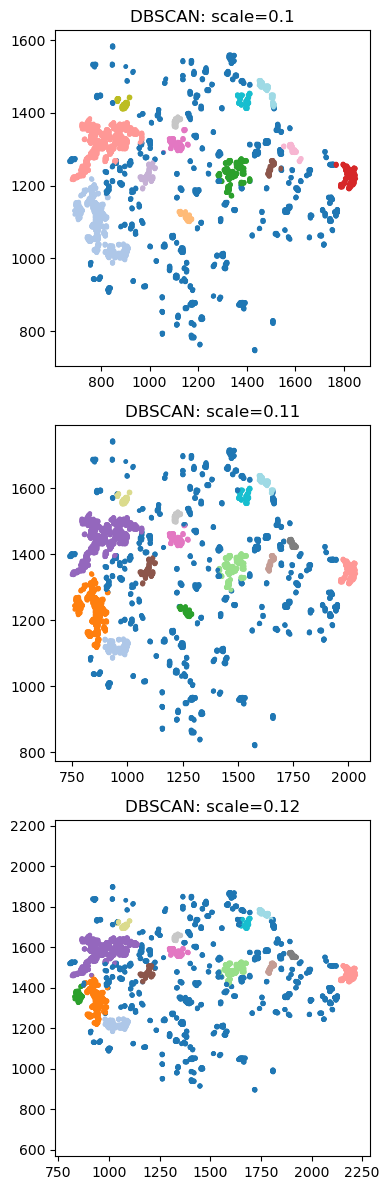

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


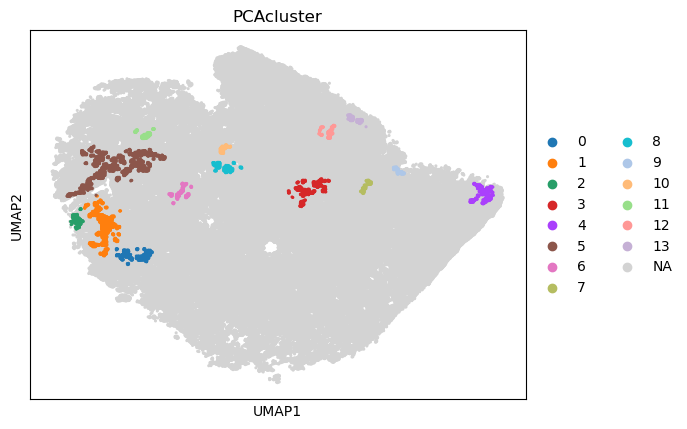

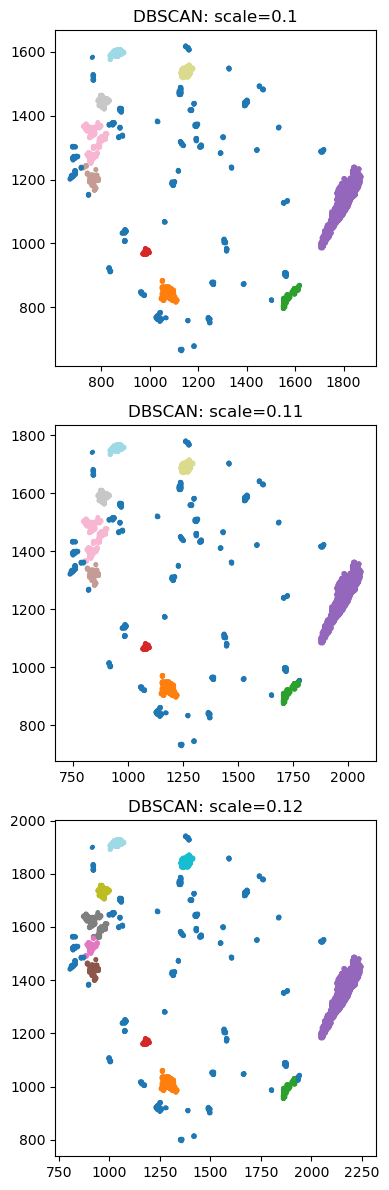

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


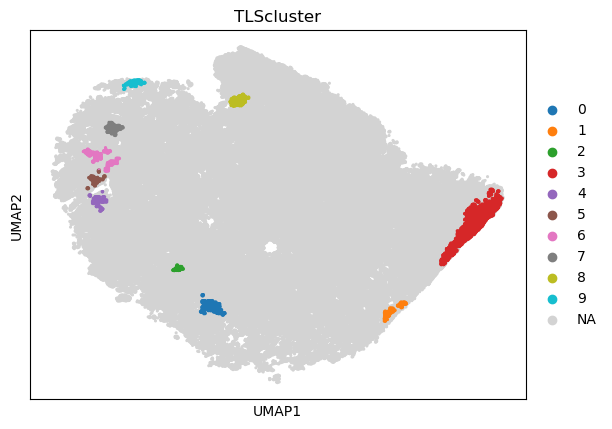

In [32]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# 1. Load AnnData
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06050D2_after_preprocess_Final.h5ad')

# 2. Prepare base obs and locations
data = adata.obs
adata.obs['loc'] = 'DNB_' + adata.obs['x'].astype(str) + '_' + adata.obs['y'].astype(str)

# ===== PCA region clustering =====
pca_df = data[data['bin50 structural annotation'] == 'LA-PCA'][['x', 'y']].copy()
pca_df['label'] = 'PCA'
X_pca = pca_df[['x', 'y']].to_numpy()

scales = [0.1, 0.11, 0.12]
fig, axes = plt.subplots(3, 1, figsize=(4, 12))
for idx, scale in enumerate(scales):
    db = DBSCAN(eps=30, min_samples=100)
    db.fit(X_pca * scale)
    labels = db.labels_
    axes[idx].scatter((X_pca * scale)[:, 0], (X_pca * scale)[:, 1], c=labels, cmap='tab20', s=5)
    axes[idx].set_title(f"DBSCAN: scale={scale}")
plt.tight_layout()
plt.axis('equal')
plt.show()

# Final cluster on last scale
db = DBSCAN(eps=30, min_samples=100)
db.fit(X_pca * scales[-1])
pca_df['dbslabel'] = db.labels_
pca_df = pca_df[~pca_df['dbslabel'].isin([-1])]
pca_df['loc'] = 'DNB_' + pca_df['x'].astype(str) + '_' + pca_df['y'].astype(str)

# merge PCA cluster to AnnData.obs
adata.obs = adata.obs.merge(pca_df[['loc', 'dbslabel']], on='loc', how='left')
adata.obs['PCAcluster'] = adata.obs['dbslabel'].astype('Int64').astype('category')
adata.obs.drop(columns=['dbslabel'], inplace=True)

# UMAP plot with cluster
sc.pl.umap(adata, color=['PCAcluster'], s=20, use_raw=False, save='PCAcluster_number_umap.pdf')

# ===== TLS region clustering =====
tls_df = data[data['bin50 structural annotation'] == 'LA-TLS'][['x', 'y']].copy()
tls_df['label'] = 'TLS'
X_tls = tls_df[['x', 'y']].to_numpy()

fig, axes = plt.subplots(3, 1, figsize=(4, 12))
for idx, scale in enumerate(scales):
    db = DBSCAN(eps=30, min_samples=100)
    db.fit(X_tls * scale)
    labels = db.labels_
    axes[idx].scatter((X_tls * scale)[:, 0], (X_tls * scale)[:, 1], c=labels, cmap='tab20', s=5)
    axes[idx].set_title(f"DBSCAN: scale={scale}")
plt.tight_layout()
plt.show()

db = DBSCAN(eps=30, min_samples=100)
db.fit(X_tls * scales[-1])
tls_df['dbslabel'] = db.labels_
tls_df = tls_df[~tls_df['dbslabel'].isin([-1])]
tls_df['loc'] = 'DNB_' + tls_df['x'].astype(str) + '_' + tls_df['y'].astype(str)

# merge TLS cluster to AnnData.obs
adata.obs = adata.obs.merge(tls_df[['loc', 'dbslabel']], on='loc', how='left', suffixes=('', '_tls'))
adata.obs['TLScluster'] = adata.obs['dbslabel'].astype('Int64').astype('category')
adata.obs.drop(columns=['dbslabel'], inplace=True)

# UMAP plot with TLS clusters
sc.pl.umap(adata, color=['TLScluster'], s=20, use_raw=False) #, save='TLScluster_number_umap.pdf'


# Define CSR

In [43]:
import numpy as np
import os

adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06050D2_after_preprocess_Final.h5ad')

def bcr_csr_annotation(adata, batch, percentile=50):
    # Remove previous CSR/classes columns if present
    for col in ['CSR', 'classes']:
        if col in adata.obs.columns:
            del adata.obs[col]

    # 1. Extract BCR heavy chain gene expression to obs
    bcr_genes = ['IGHG1', 'IGHG2', 'IGHG3', 'IGHG4', 'IGHA1', 'IGHA2', 'IGHM', 'IGHD', 'IGHE']
    for gene in bcr_genes:
        value_col = f"{gene}_value"
        if gene in adata.var_names:
            expr = adata[:, gene].X
            if hasattr(expr, "toarray"):  # sparse
                expr = expr.toarray().flatten()
            else:
                expr = np.ravel(expr)
            adata.obs[value_col] = expr
        else:
            print(f"[Warning] {gene} not in adata.var_names, skipped.")

    # 2. Isotype positivity Q3 (or configurable)
    for gene in bcr_genes:
        value_col = f"{gene}_value"
        judge_col = f"{gene}_judge"
        if value_col in adata.obs.columns:
            vals = adata.obs[value_col]
            q = np.percentile(vals[vals > 0], percentile) if np.any(vals > 0) else 0
            adata.obs[judge_col] = np.where(vals > q, 'yes', 'other')

    # 3. Family-level positivity
    igg_judge_cols = [f'IGHG{i}_judge' for i in range(1, 5) if f'IGHG{i}_judge' in adata.obs.columns]
    iga_judge_cols = [c for c in ['IGHA1_judge', 'IGHA2_judge'] if c in adata.obs.columns]

    adata.obs['IGHG_sum'] = adata.obs[igg_judge_cols].eq('yes').sum(axis=1) if igg_judge_cols else 0
    adata.obs['IGHA_sum'] = adata.obs[iga_judge_cols].eq('yes').sum(axis=1) if iga_judge_cols else 0
    adata.obs['IGHG_judge'] = np.where(adata.obs['IGHG_sum'] >= 1, 'yes', 'other')
    adata.obs['IGHA_judge'] = np.where(adata.obs['IGHA_sum'] >= 1, 'yes', 'other')

    # 4. CSR判定，五主型组合
    main_judge_cols = ['IGHG_judge', 'IGHA_judge', 'IGHM_judge', 'IGHD_judge', 'IGHE_judge']
    judge_cols = [c for c in main_judge_cols if c in adata.obs.columns]
    adata.obs['isotype_sum'] = adata.obs[judge_cols].eq('yes').sum(axis=1)
    adata.obs['CSR'] = 'NA'
    adata.obs.loc[adata.obs['isotype_sum'] > 1, 'CSR'] = 'yes'
    adata.obs.loc[adata.obs['isotype_sum'] == 1, 'CSR'] = 'no'

    # 5. "classes" annotation: positive main types used
    gene_names = [c.replace('_judge', '') for c in judge_cols]
    def judge_to_classes(row):
        genes = [gene for gene, col in zip(gene_names, judge_cols) if row[col] == 'yes']
        return ",".join(genes) if genes else ""
    adata.obs['classes'] = ""
    mask = adata.obs['CSR'] == 'yes'
    if mask.any():
        adata.obs.loc[mask, 'classes'] = adata.obs.loc[mask].apply(judge_to_classes, axis=1)
    print(f'[INFO] BCR isotype annotation and CSR logic complete for {batch}.')


bcr_csr_annotation(adata, batch="D06053D2")

[INFO] BCR isotype annotation and CSR logic complete for D06053D2.


# Preprocess of tree

In [58]:
import scanpy as sc
import pandas as pd
import numpy as np

# ===============================
# Parameters and data import
# ===============================
TRA_MIN_READS       = 1
TRB_MIN_READS       = 1
TCR_FILTER_READS    = 5
IGH_MIN_READS       = 1
IGKL_MIN_READS      = 1
BCR_XCR_MIN_READS   = 5
FINAL_COL_SUFFIX    = "15"
WORKING_SUFFIX      = "XCR"
READ_LENGTH         = 130

meta = pd.read_csv('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/1.23_combind/merged_meta_tsv.gz', sep='\t')
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06050D2_after_preprocess_Final.h5ad')

# Clean up obs columns
del_cols = ['TRAcdr3aa', 'TRBcdr3aa', 'mutation_percent', 'CSR', 'IGK/Lcdr3aa', 'IGKorIGL', 'IGHcdr3aa','classes_meta', 'classes_stereo']
adata.obs = adata.obs.drop(del_cols, axis=1, errors='ignore')
adata.obs.index = adata.obs.index.astype(str)

# ========== 1. General filtering helper ==========
def filter_by_readcount_and_function(df, min_reads=4, readid_col='readId'):
    counts = df.groupby('cid_umi')[readid_col].nunique()
    valid = counts[counts >= min_reads].index
    df = df[df['cid_umi'].isin(valid)]
    df = df[df['functional'] == 'Functional']
    return df

# ========== 2. TCR CDR3aa extraction with double voting ==========
def extract_best_cdr3aa(df, chain_letter="A", cdr3_col="junction_aa", umi_col="cid_umi", cellid_col="cellID"):
    unique_counts = df.groupby(umi_col)[cdr3_col].nunique().reset_index()
    multiple_cdr3aa = unique_counts[unique_counts[cdr3_col] > 1]
    unique_cdr3aa = unique_counts[unique_counts[cdr3_col] == 1]
    retrievable_umi = multiple_cdr3aa[multiple_cdr3aa[cdr3_col] <= 10][umi_col]
    retrievable = df[df[umi_col].isin(retrievable_umi)]
    if retrievable.shape[0] > 0:
        cdr3aa_counts = retrievable.groupby([umi_col, cdr3_col]).size().reset_index(name="count")
        voted_cdr3aa = cdr3aa_counts.loc[cdr3aa_counts.groupby(umi_col)["count"].idxmax()]
    else:
        voted_cdr3aa = pd.DataFrame(columns=[umi_col, cdr3_col, "count"])
    df1 = pd.concat([
        df[df[umi_col].isin(unique_cdr3aa[umi_col].unique())],
        df[df[umi_col].isin(voted_cdr3aa[umi_col].unique())]
    ], ignore_index=True)
    unique_counts = df1.groupby(cellid_col)[cdr3_col].nunique().reset_index()
    multiple_cdr3aa = unique_counts[unique_counts[cdr3_col] > 1]
    unique_cdr3aa = unique_counts[unique_counts[cdr3_col] == 1]
    retrievable_id = multiple_cdr3aa[multiple_cdr3aa[cdr3_col] <= 10][cellid_col]
    retrievable = df1[df1[cellid_col].isin(retrievable_id)]
    if retrievable.shape[0] > 0:
        cdr3aa_counts = retrievable.groupby([cellid_col, cdr3_col]).size().reset_index(name="count")
        voted_cdr3aa = cdr3aa_counts.loc[cdr3aa_counts.groupby(cellid_col)["count"].idxmax()]
    else:
        voted_cdr3aa = pd.DataFrame(columns=[cellid_col, cdr3_col, "count"])
    result = df1[df1[cellid_col].isin(unique_cdr3aa[cellid_col])][[cellid_col, cdr3_col]].drop_duplicates(subset=[cellid_col, cdr3_col])
    result = pd.concat([result, voted_cdr3aa[[cellid_col, cdr3_col]]], ignore_index=True)
    out_col = f"TR{chain_letter}cdr3aa"
    result.rename(columns={cdr3_col: out_col, cellid_col: "cellID"}, inplace=True)
    result["cellID"] = result["cellID"].astype(str)
    return result[["cellID", out_col]]

# ========== 3. Extract cellIDs for T and B/plasma cells ==========
TCR_cellid = adata.obs[adata.obs['anno'] == 'Tcell']['cellID'].astype(int).tolist()
BCR_cellid = adata.obs[adata.obs['anno'].isin(['b_cell', 'plasma_cell'])]['cellID'].tolist()

# ========== 4. TCR assignment & voting ==========
TRA = meta[(meta['topChains'] == 'TRA') & (meta['cellID'].isin(TCR_cellid))].copy()
TRB = meta[(meta['topChains'] == 'TRB') & (meta['cellID'].isin(TCR_cellid))].copy()
TRA['cid_umi'] = TRA['cid'] + '_' + TRA['umi']
TRB['cid_umi'] = TRB['cid'] + '_' + TRB['umi']

filtered_tra = filter_by_readcount_and_function(TRA, min_reads=TRA_MIN_READS)
filtered_trb = filter_by_readcount_and_function(TRB, min_reads=TRB_MIN_READS)

result_TRA = extract_best_cdr3aa(filtered_tra, chain_letter="A")
adata.obs['cellID'] = adata.obs['cellID'].astype(str)
adata.obs = adata.obs.merge(result_TRA, on="cellID", how="left")

result_TRB = extract_best_cdr3aa(filtered_trb, chain_letter="B")
adata.obs = adata.obs.merge(result_TRB, on="cellID", how="left")

print('--- First TCR voting, step 1 summary ---')
print(f"Annotated T cells: {len(TCR_cellid)}")
print(f"TRA positive cells: {adata.obs[adata.obs['TRAcdr3aa'].notna()].shape[0]}")
print(f"TRB positive cells: {adata.obs[adata.obs['TRBcdr3aa'].notna()].shape[0]}")
print(f"TRA & TRB double positive cells: {adata.obs[(adata.obs['TRAcdr3aa'].notna()) & (adata.obs['TRBcdr3aa'].notna())].shape[0]}")

# ----- Negative assignment and XCR voting -----
meta_subset = meta[~meta['cellID'].isin(TCR_cellid)].copy()
meta_subset['TCRorBCR'] = meta_subset['topChains'].map(lambda x: 'TCR' if x in ['TRA','TRB'] else 'BCR')
meta_subset['cid_umi'] = meta_subset['cid'] + '_' + meta_subset['umi']
meta_subset['loc'] = meta_subset['x'].astype(str) + '_' + meta_subset['y'].astype(str)
meta_tcr = meta_subset[meta_subset['TCRorBCR'] == 'TCR'].copy()
meta_tcr = filter_by_readcount_and_function(meta_tcr, min_reads=TCR_FILTER_READS)
meta_tcr['cellID'] = meta_tcr['cellID'].astype(str)

# TRA negative voting
result_TRA_neg = extract_best_cdr3aa(meta_tcr[meta_tcr['topChains'] == 'TRA'], chain_letter="A")
result_TRA_neg.rename(columns={'TRAcdr3aa': f'TRAcdr3aa_{WORKING_SUFFIX}'}, inplace=True)
adata.obs = adata.obs.merge(result_TRA_neg, on='cellID', how='left')
# TRB negative voting
result_TRB_neg = extract_best_cdr3aa(meta_tcr[meta_tcr['topChains'] == 'TRB'], chain_letter="B")
result_TRB_neg.rename(columns={'TRBcdr3aa': f'TRBcdr3aa_{WORKING_SUFFIX}'}, inplace=True)
adata.obs = adata.obs.merge(result_TRB_neg, on='cellID', how='left')

# Masking and overwrite NAs
mask = (~adata.obs[f'TRAcdr3aa_{WORKING_SUFFIX}'].isna()) & (~adata.obs[f'TRBcdr3aa_{WORKING_SUFFIX}'].isna())
adata.obs.loc[~mask, [f'TRAcdr3aa_{WORKING_SUFFIX}', f'TRBcdr3aa_{WORKING_SUFFIX}']] = np.nan

for col in ['TRAcdr3aa', 'TRBcdr3aa']:
    if col not in adata.obs:
        adata.obs[col] = np.nan

mask_tra = adata.obs['TRAcdr3aa'].isna()
adata.obs.loc[mask_tra, 'TRAcdr3aa'] = adata.obs.loc[mask_tra, f'TRAcdr3aa_{WORKING_SUFFIX}']
mask_trb = adata.obs['TRBcdr3aa'].isna()
adata.obs.loc[mask_trb, 'TRBcdr3aa'] = adata.obs.loc[mask_trb, f'TRBcdr3aa_{WORKING_SUFFIX}']

# Final: rename columns, clean temp working cols
adata.obs.rename(columns={'TRAcdr3aa': f'TRAcdr3aa_{FINAL_COL_SUFFIX}', 'TRBcdr3aa': f'TRBcdr3aa_{FINAL_COL_SUFFIX}'}, inplace=True)
del adata.obs[f'TRAcdr3aa_{WORKING_SUFFIX}']
del adata.obs[f'TRBcdr3aa_{WORKING_SUFFIX}']

print('--- Second TCR voting, step 2 summary ---')
print(f"Annotated T cells: {len(TCR_cellid)}")
print(f"TRA positive cells: {adata.obs[adata.obs[f'TRAcdr3aa_{FINAL_COL_SUFFIX}'].notna()].shape[0]}")
print(f"TRB positive cells: {adata.obs[adata.obs[f'TRBcdr3aa_{FINAL_COL_SUFFIX}'].notna()].shape[0]}")
print(f"TRA & TRB double positive cells: {adata.obs[(adata.obs[f'TRAcdr3aa_{FINAL_COL_SUFFIX}'].notna()) & (adata.obs[f'TRBcdr3aa_{FINAL_COL_SUFFIX}'].notna())].shape[0]}")

# ========== 5. BCR assignment & voting ==========
def calculate_frequency(mutation):
    return sum(mutation.count(base) for base in 'SDI')

def extract_best_bcr_chain(df, chain_name='IGH', readlength=READ_LENGTH):
    df['frequency'] = df['allVAlignments'].apply(calculate_frequency)
    df['mutation_percent'] = df['frequency'] / readlength
    unique_counts = df.groupby('cid_umi')['junction_aa'].nunique().reset_index()
    multi = unique_counts[unique_counts['junction_aa'] > 1]
    uniq = unique_counts[unique_counts['junction_aa'] == 1]
    retrievable_umi = multi[multi['junction_aa'] <= 10]['cid_umi']
    retrievable = df[df['cid_umi'].isin(retrievable_umi)]
    cdr3aa_counts = retrievable.groupby(['cid_umi', 'junction_aa']).size().reset_index(name='count')
    voted_cdr3aa = cdr3aa_counts.iloc[cdr3aa_counts.groupby('cid_umi')['count'].idxmax().values]
    df1 = pd.concat([
        df[df['cid_umi'].isin(uniq['cid_umi'].unique())],
        df[df['cid_umi'].isin(voted_cdr3aa['cid_umi'].unique())]
    ], ignore_index=True)
    unique_counts = df1.groupby('cellID')['junction_aa'].nunique().reset_index()
    multi = unique_counts[unique_counts['junction_aa'] > 1]
    uniq = unique_counts[unique_counts['junction_aa'] == 1]
    retrievable_id = multi[multi['junction_aa'] <= 10]['cellID']
    retrievable = df1[df1['cellID'].isin(retrievable_id)]
    cdr3aa_counts = retrievable.groupby(['cellID', 'junction_aa']).size().reset_index(name='count')
    voted_cdr3aa = cdr3aa_counts.iloc[cdr3aa_counts.groupby('cellID')['count'].idxmax().values]
    result = df1[df1['cellID'].isin(uniq['cellID'])][['cellID', 'junction_aa']].drop_duplicates(subset=['cellID', 'junction_aa'])
    result = pd.concat([result, voted_cdr3aa[['cellID', 'junction_aa']]], ignore_index=True)
    result['cellID'] = result['cellID'].astype(str)
    df1['cellID'] = df1['cellID'].astype(str)
    result = pd.merge(df1, result, on=['cellID', 'junction_aa'])
    result = result.groupby(['cellID', 'junction_aa'])['mutation_percent'].median().reset_index()
    result.rename(columns={'junction_aa': f'{chain_name}cdr3aa'}, inplace=True)
    return result

def extract_best_igkl_chain(df):
    unique_counts = df.groupby('cid_umi')['junction_aa'].nunique().reset_index()
    multi = unique_counts[unique_counts['junction_aa'] > 1]
    uniq = unique_counts[unique_counts['junction_aa'] == 1]
    retrievable_umi = multi[multi['junction_aa'] <= 10]['cid_umi']
    retrievable = df[df['cid_umi'].isin(retrievable_umi)]
    cdr3aa_counts = retrievable.groupby(['cid_umi', 'junction_aa']).size().reset_index(name='count')
    voted_cdr3aa = cdr3aa_counts.iloc[cdr3aa_counts.groupby('cid_umi')['count'].idxmax().values]
    df1 = pd.concat([
        df[df['cid_umi'].isin(uniq['cid_umi'].unique())],
        df[df['cid_umi'].isin(voted_cdr3aa['cid_umi'].unique())]
    ], ignore_index=True)
    unique_counts = df1.groupby('cellID')['topChains'].nunique().reset_index()
    multi = unique_counts[unique_counts['topChains'] > 1]
    uniq = unique_counts[unique_counts['topChains'] == 1]
    retrievable = df1[df1['cellID'].isin(multi['cellID'])]
    cdr3aa_counts = retrievable.groupby(['cellID', 'topChains']).size().reset_index(name='count')
    voted_chain = cdr3aa_counts.iloc[cdr3aa_counts.groupby('cellID')['count'].idxmax().values]
    voted_chain['cellID_iso'] = voted_chain['cellID'].map(str) + voted_chain['topChains']
    df1['cellID_iso'] = df1['cellID'].map(str) + df1['topChains']
    df2 = pd.concat([
        df1[df1['cellID_iso'].isin(voted_chain['cellID_iso'])],
        df1[df1['cellID'].isin(uniq['cellID'])]
    ], ignore_index=True)
    unique_counts = df2.groupby('cellID')['junction_aa'].nunique().reset_index()
    multi = unique_counts[unique_counts['junction_aa'] > 1]
    uniq = unique_counts[unique_counts['junction_aa'] == 1]
    retrievable_id = multi[multi['junction_aa'] <= 10]['cellID']
    retrievable = df2[df2['cellID'].isin(retrievable_id)]
    cdr3aa_counts = retrievable.groupby(['cellID', 'junction_aa']).size().reset_index(name='count')
    voted_cdr3aa = cdr3aa_counts.iloc[cdr3aa_counts.groupby('cellID')['count'].idxmax().values]
    result = df2[df2['cellID'].isin(uniq['cellID'])][['cellID', 'junction_aa']].drop_duplicates(subset=['cellID', 'junction_aa'])
    result = pd.concat([result, voted_cdr3aa[['cellID', 'junction_aa']]], ignore_index=True)
    topChains_map = df2[['cellID', 'topChains']].drop_duplicates(subset=['cellID', 'topChains']).set_index('cellID')['topChains']
    result['IGKorIGL'] = result['cellID'].map(topChains_map)
    result.rename(columns={'junction_aa': 'IGK/Lcdr3aa'}, inplace=True)
    result['cellID'] = result['cellID'].astype(str)
    return result

# Extract BCR chain info and annotate
IGH  = meta[meta['topChains'] == 'IGH']
IGH  = IGH[IGH['cellID'].isin(BCR_cellid)]
IGH['cid_umi'] = IGH['cid'] + '_' + IGH['umi']

IGKL = meta[meta['topChains'].isin(['IGK', 'IGL'])]
IGKL = IGKL[IGKL['cellID'].isin(BCR_cellid)]
IGKL['cid_umi'] = IGKL['cid'] + '_' + IGKL['umi']

filtered_igh  = filter_by_readcount_and_function(IGH,  min_reads=IGH_MIN_READS)
filtered_igkl = filter_by_readcount_and_function(IGKL, min_reads=IGKL_MIN_READS)
BCR = pd.concat([filtered_igh, filtered_igkl], ignore_index=True)

result_igh  = extract_best_bcr_chain(BCR[BCR['topChains'] == 'IGH'], chain_name='IGH')
result_igkl = extract_best_igkl_chain(BCR[BCR['topChains'].isin(['IGK', 'IGL'])])

adata.obs['cellID'] = adata.obs['cellID'].astype(str)
adata.obs = adata.obs.merge(result_igh, on='cellID', how='left')
adata.obs = adata.obs.merge(result_igkl, on='cellID', how='left')

print('--- First BCR voting, step 1 summary ---')
print(f"Annotated B/plasma cells: {len(BCR_cellid)}")
print(f"IGH positive cells: {adata.obs[adata.obs['IGHcdr3aa'].notna()].shape[0]}")
print(f"IGK/L positive cells: {adata.obs[adata.obs['IGK/Lcdr3aa'].notna()].shape[0]}")
print(f"IGH & IGK/L double positive cells: {adata.obs[(adata.obs['IGHcdr3aa'].notna()) & (adata.obs['IGK/Lcdr3aa'].notna())].shape[0]}")

# BCR negative assignment
meta_subset = meta[~meta['cellID'].isin(BCR_cellid)].copy()
meta_subset['TCRorBCR'] = meta_subset['topChains'].map(lambda x: 'TCR' if x in ['TRA', 'TRB'] else 'BCR')
meta_subset['cid_umi'] = meta_subset['cid'] + '_' + meta_subset['umi']
meta_subset['loc'] = meta_subset['x'].astype(str) + '_' + meta_subset['y'].astype(str)
meta_bcr = meta_subset[meta_subset['TCRorBCR'] == 'BCR'].copy()
meta_bcr = filter_by_readcount_and_function(meta_bcr, min_reads=BCR_XCR_MIN_READS)
meta_bcr['cellID'] = meta_bcr['cellID'].astype(str)

result_igh_xcr = extract_best_bcr_chain(meta_bcr[meta_bcr['topChains'] == 'IGH'], chain_name='IGH')
result_igh_xcr.rename(columns={'IGHcdr3aa': f'IGHcdr3aa_{WORKING_SUFFIX}','mutation_percent':f'mutation_percent_{WORKING_SUFFIX}'}, inplace=True)
adata.obs = adata.obs.merge(result_igh_xcr, on='cellID', how='left')

result_igkl_xcr = extract_best_igkl_chain(meta_bcr[meta_bcr['topChains'].isin(['IGK', 'IGL'])])
result_igkl_xcr.rename(columns={'IGK/Lcdr3aa': f'IGK/Lcdr3aa_{WORKING_SUFFIX}', 'IGKorIGL': f'IGKorIGL_{WORKING_SUFFIX}'}, inplace=True)
adata.obs = adata.obs.merge(result_igkl_xcr, on='cellID', how='left')

mask = (
    (~adata.obs[f'IGHcdr3aa_{WORKING_SUFFIX}'].isna())
    & (~adata.obs[f'IGK/Lcdr3aa_{WORKING_SUFFIX}'].isna())
    & (~adata.obs[f'IGKorIGL_{WORKING_SUFFIX}'].isna())
    & (~adata.obs[f'mutation_percent_{WORKING_SUFFIX}'].isna())
)
adata.obs.loc[~mask, [
    f'IGHcdr3aa_{WORKING_SUFFIX}',
    f'IGK/Lcdr3aa_{WORKING_SUFFIX}',
    f'IGKorIGL_{WORKING_SUFFIX}',
    f'mutation_percent_{WORKING_SUFFIX}'
]] = np.nan

for col in ['IGHcdr3aa', 'IGK/Lcdr3aa', 'IGKorIGL']:
    if col not in adata.obs:
        adata.obs[col] = np.nan

mask_igh = adata.obs['IGHcdr3aa'].isna()
adata.obs.loc[mask_igh, 'IGHcdr3aa'] = adata.obs.loc[mask_igh, f'IGHcdr3aa_{WORKING_SUFFIX}']
mask_mutation_percent = adata.obs['mutation_percent'].isna()
adata.obs.loc[mask_mutation_percent, 'mutation_percent'] = adata.obs.loc[mask_mutation_percent, f'mutation_percent_{WORKING_SUFFIX}']
mask_igkl = adata.obs['IGK/Lcdr3aa'].isna()
adata.obs.loc[mask_igkl, 'IGK/Lcdr3aa'] = adata.obs.loc[mask_igkl, f'IGK/Lcdr3aa_{WORKING_SUFFIX}']
mask_igkorigl = adata.obs['IGKorIGL'].isna()
adata.obs.loc[mask_igkorigl, 'IGKorIGL'] = adata.obs.loc[mask_igkorigl, f'IGKorIGL_{WORKING_SUFFIX}']

adata.obs.rename(columns={
    'IGHcdr3aa': f'IGHcdr3aa_{FINAL_COL_SUFFIX}',
    'mutation_percent': f'mutation_percent_{FINAL_COL_SUFFIX}',
    'IGK/Lcdr3aa': f'IGK/Lcdr3aa_{FINAL_COL_SUFFIX}',
    'IGKorIGL': f'IGKorIGL_{FINAL_COL_SUFFIX}'
}, inplace=True)
del adata.obs[f'IGHcdr3aa_{WORKING_SUFFIX}']
del adata.obs[f'IGK/Lcdr3aa_{WORKING_SUFFIX}']
del adata.obs[f'IGKorIGL_{WORKING_SUFFIX}']
del adata.obs[f'mutation_percent_{WORKING_SUFFIX}']

print('--- Second BCR voting, step 2 summary ---')
print(f"Annotated B/plasma cells: {len(BCR_cellid)}")
print(f"IGH positive cells: {adata.obs[adata.obs[f'IGHcdr3aa_{FINAL_COL_SUFFIX}'].notna()].shape[0]}")
print(f"IGK/L positive cells: {adata.obs[adata.obs[f'IGK/Lcdr3aa_{FINAL_COL_SUFFIX}'].notna()].shape[0]}")
print(f"IGH & IGK/L double positive cells: {adata.obs[(adata.obs[f'IGHcdr3aa_{FINAL_COL_SUFFIX}'].notna()) & (adata.obs[f'IGK/Lcdr3aa_{FINAL_COL_SUFFIX}'].notna())].shape[0]}")
print(f"Final output columns: IGHcdr3aa_{FINAL_COL_SUFFIX}, IGK/Lcdr3aa_{FINAL_COL_SUFFIX}, IGKorIGL_{FINAL_COL_SUFFIX}")

# ===============================
# ========== IGH majority VDJ voting & save ==========

# Filter for IGH positive cells
adata.obs['cellID'] = adata.obs['cellID'].astype(str)
IGH_id = adata.obs[adata.obs[f'IGHcdr3aa_{FINAL_COL_SUFFIX}'].notna()]['cellID'].tolist()
meta['cellID'] = meta['cellID'].astype(str)
IGH_meta = meta[(meta['topChains'] == 'IGH') & (meta['cellID'].isin(IGH_id))].copy()

# Only keep records matching cellID and CDR3aa
keys = adata.obs[adata.obs[f'IGHcdr3aa_{FINAL_COL_SUFFIX}'].notna()][['cellID', f'IGHcdr3aa_{FINAL_COL_SUFFIX}']].values.tolist()
IGH_meta = IGH_meta[IGH_meta[['cellID', 'junction_aa']].apply(tuple, axis=1).isin([tuple(k) for k in keys])]

# Drop records missing v_call/d_call/j_call/c_call
meta_vdj = IGH_meta.dropna(subset=['v_call', 'd_call', 'j_call', 'c_call']).reset_index(drop=True)

def get_majority_vote_first_five(series):
    return series.str[:5].value_counts().idxmax()

vdjc_votes = meta_vdj.groupby('cellID')[['v_call', 'd_call', 'j_call', 'c_call']].agg(get_majority_vote_first_five).reset_index()
vdjc_votes.rename(columns={
    'v_call': 'v_call_majority',
    'd_call': 'd_call_majority',
    'j_call': 'j_call_majority',
    'c_call': 'c_call_majority'
}, inplace=True)

meta_vdj['cellID'] = meta_vdj['cellID'].astype(str)
vdjc_votes['cellID'] = vdjc_votes['cellID'].astype(str)
merged_df = meta_vdj.merge(vdjc_votes, on='cellID', how='inner')

filtered_df = merged_df[
    (merged_df['v_call'].str[:5] == merged_df['v_call_majority']) &
    (merged_df['d_call'].str[:5] == merged_df['d_call_majority']) &
    (merged_df['j_call'].str[:5] == merged_df['j_call_majority']) &
    (merged_df['c_call'].str[:5] == merged_df['c_call_majority'])
]

result_unique = filtered_df.drop_duplicates(subset='cellID', keep='first').copy()
result_unique['junction_length'] = result_unique['junction'].str.len()

print(result_unique['isotypePrimary'].value_counts())
result_unique.to_csv('IGH_for_DefineClone_aftermodifiy.tsv', sep='\t', index=False)
print(f"Saved {result_unique.shape[0]} IGH cells for clone calling: IGH_for_DefineClone_aftermodifiy.tsv")

/tmp/ipykernel_2572206/3111934381.py:18: DtypeWarning: Columns (7,19,21) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/1.23_combind/merged_meta_tsv.gz', sep='\t')
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


--- First TCR voting, step 1 summary ---
Annotated T cells: 4526
TRA positive cells: 2041
TRB positive cells: 1142
TRA & TRB double positive cells: 587


/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


--- Second TCR voting, step 2 summary ---
Annotated T cells: 4526
TRA positive cells: 2074
TRB positive cells: 1175
TRA & TRB double positive cells: 620


/tmp/ipykernel_2572206/3111934381.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['frequency'] = df['allVAlignments'].apply(calculate_frequency)
/tmp/ipykernel_2572206/3111934381.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mutation_percent'] = df['frequency'] / readlength
/tmp/ipykernel_2572206/3111934381.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

--- First BCR voting, step 1 summary ---
Annotated B/plasma cells: 8419
IGH positive cells: 6025
IGK/L positive cells: 4561
IGH & IGK/L double positive cells: 3476


/tmp/ipykernel_2572206/3111934381.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['frequency'] = df['allVAlignments'].apply(calculate_frequency)
/tmp/ipykernel_2572206/3111934381.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mutation_percent'] = df['frequency'] / readlength
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: int

--- Second BCR voting, step 2 summary ---
Annotated B/plasma cells: 8419
IGH positive cells: 10785
IGK/L positive cells: 9321
IGH & IGK/L double positive cells: 8236
Final output columns: IGHcdr3aa_15, IGK/Lcdr3aa_15, IGKorIGL_15
IGHG    6988
IGHM    2270
IGHA     147
IGHD       1
IGHE       1
Name: isotypePrimary, dtype: int64
Saved 10776 IGH cells for clone calling: IGH_for_DefineClone_aftermodifiy.tsv


# Threshold of Define clone

In [ ]:
suppressPackageStartupMessages({
  library(alakazam)
  library(dplyr)
  library(ggplot2)
  library(shazam)
})

# 1. Read IGH meta data (tab-delimited)
data <- read.table("IGH_for_DefineClone_aftermodifiy.tsv", header = TRUE, sep = "\t", stringsAsFactors = FALSE)

# 2. Set locus field used by alakazam/shazam
data$locus <- data$topChains

# 3. Compute distance to nearest for each sequence (normalized Hamming)
dist_ham <- distToNearest(data,
                          sequenceColumn="junction",
                          vCallColumn="v_call_majority",
                          jCallColumn="j_call_majority",
                          model="ham", normalize="len", nproc=1)

# 4. Automatically find optimal threshold using density curve
output <- findThreshold(dist_ham$dist_nearest, method="density")
threshold <- output@threshold

# 5. Plot histogram, density, and threshold for clone partitioning
plot(output, title="Density Method")

# 6. Output threshold summary
print(output)

# Build tree

In [ ]:
#!/usr/bin/env Rscript

# Spatial VDJ Method for Lineage Tree (Phylip-based)
# Optimized & cleaned to centralize all paths and filenames at the top.
# Includes robust handling for missing columns (e.g., c_call_raw) and auto-generated columns (e.g., ...1).

# ==============================
# Configuration: paths & filenames
# ==============================
# Base output directory (all outputs will be saved under this directory)
OUTPUT_DIR <- "/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/analysis/Define_clone"

# Input files
INPUT_IGH_TSV <- "/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/IGH_for_DefineClone_aftermodifiy_clone-pass.tsv"
INPUT_METADATA_CSV <- "/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/all_cluster_meta.csv"

# External executable
PHYLIP_EXEC <- "/data1/zhangyang/Method/phylip-3.697/exe/dnapars"

# Output filenames (relative to OUTPUT_DIR; names must remain unchanged)
OUT_P1_CLONEFAMILY_MATRIX_CSV <- "P1_clonefamily_matrix.csv"
OUT_AIRR_GAPPED_TSV <- "IGH_1_airr_lineage_tree_gapped.tsv"
OUT_AIRR_CLEANED_TSV <- "IGH_7_airr_lineage_tree_cleaned.tsv"
OUT_TREE_INPUT_CSV <- "LC_p1_reads_processed_IGH_filtered_for_tree.csv"

# ==============================
# Optional: override OUTPUT_DIR via CLI
# ==============================
args <- commandArgs(trailingOnly = TRUE)
if (length(args) > 1 && args[1] == "--output_dir") {
  OUTPUT_DIR <- args[2]
}
if (!dir.exists(OUTPUT_DIR)) {
  dir.create(OUTPUT_DIR, recursive = TRUE)
}

# ==============================
# Libraries
# ==============================
suppressPackageStartupMessages({
  library(stringr)
  library(dplyr)
  library(tidyverse)
  library(alakazam)
  library(igraph)
  library(qdapTools)
  library(reshape2)
})
source("/data2/zhangyang/Method/DefineClone/lineage_tree(1).R")
# ==============================
# Helper Functions
# ==============================
get_v_alignment <- function(sequence, pattern) {
  pos <- as.numeric(str_split_fixed(pattern, "\\|", 7)[1, 1:5])
  v_seq <- substr(sequence, pos[4] + 1, pos[5])
  paste0(strrep(".", pos[1]), v_seq)
}

get_v_germline <- function(sequence, pattern) {
  pattern_split <- str_split_fixed(pattern, "\\|", 7)
  pos <- as.numeric(pattern_split[1, 1:5])
  v_germline <- substr(sequence, pos[4] + 1, pos[5])
  mutations <- gsub("^S", "", pattern_split[1, 6]) %>%
    str_split("S") %>% .[[1]]
  if (pattern_split[1, 6] != "") {
    for (mut in mutations) {
      from <- substr(mut, 1, 1)
      posm <- as.numeric(substr(mut, 2, nchar(mut)-1))
      # Keep original logic (assign 'from')
      substr(v_germline, posm + 1, posm + 1) <- from
    }
  }
  paste0(strrep(".", pos[1]), v_germline)
}

exportSubcloneAnnotation <- function(clone, changeo_clone, graph_df, clone_name, out_dir) {
  matchlist <- as_tibble(changeo_clone@data) %>%
    select(sequence_id, sequence) %>%
    mutate(sequence = gsub("^[N]*|[N]*$", "", sequence))
  changeo_annotated <- merge(matchlist, graph_df, by.x = "sequence_id", by.y = "to", all.x = TRUE)
  selected <- clone %>%
    select(sequence_id, clone_family_id, v_call, d_call, j_call, c_call, cellid,
           leiden, duplicate_count, st_barcode, sequence_alignment) %>%
    mutate(sequence_alignment = gsub("\\.", "", sequence_alignment))
  final_merged <- merge(selected, changeo_annotated, by.x = "sequence_alignment", by.y = "sequence",
                        all.x = TRUE)
  # reconcile sequence_id if merge created x/y variants
  if ("sequence_id.x" %in% names(final_merged) && "sequence_id.y" %in% names(final_merged)) {
    final_merged <- final_merged %>%
      mutate(sequence_id = coalesce(sequence_id.x, sequence_id.y)) %>%
      select(-sequence_id.x, -sequence_id.y)
  }
  if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)
  write.csv(final_merged, file.path(out_dir, paste0(clone_name, "_subclone_annotation.csv")), row.names = FALSE)
  return(final_merged)
}

# ==============================
# 1. Read and preprocess input
# ==============================
LC_p1_reads <- read.delim(INPUT_IGH_TSV, sep = '\t')
LC_p1_reads$sequence_id <- NULL

LC_p1_reads <- LC_p1_reads %>%
  mutate(combineisotype = ifelse(!is.na(isotypeprimary), isotypeprimary, "IGH"))
LC_p1_reads <- LC_p1_reads[!is.na(LC_p1_reads$cdr3begin), ]
names(LC_p1_reads)[names(LC_p1_reads) == "allvalignments"] <- "mutation"
LC_p1_reads <- LC_p1_reads[!(grepl("I|D", LC_p1_reads$mutation)), ]
names(LC_p1_reads)[names(LC_p1_reads) == "clone_id"] <- "clone_family_id"

# Add spatial barcode
LC_p1_reads <- LC_p1_reads %>%
  mutate(st_barcode = paste0("DNB_", floor(x / 50) * 50, "_", floor(y / 50) * 50)) %>%
  select(st_barcode, everything())

# Count matrix output
family_count_matrix <- split(LC_p1_reads$st_barcode, factor(LC_p1_reads$clone_family_id)) %>% mtabulate()
write.csv(family_count_matrix, file.path(OUTPUT_DIR, OUT_P1_CLONEFAMILY_MATRIX_CSV))

# ==============================
# 2. Metadata join and initial export
# ==============================
all_metadata <- read_csv(INPUT_METADATA_CSV, show_col_types = FALSE)
# Remove auto-generated unnamed column if present
if ("...1" %in% names(all_metadata)) {
  all_metadata <- all_metadata %>% select(-`...1`)
}
names(all_metadata)[names(all_metadata) == "bin50_location_id"] <- "st_barcode"
names(all_metadata)[names(all_metadata) == "annotation"] <- "annotation2"

LC_p1_reads <- LC_p1_reads %>%
  left_join(all_metadata %>% select(st_barcode, annotation2, leiden, TLScluster, x, y), by = "st_barcode")
names(LC_p1_reads)[names(LC_p1_reads) == "readid"] <- "readname"
LC_p1_reads$sequence_id <- paste0("clone.", LC_p1_reads$clone_family_id)

write.table(LC_p1_reads,
            file = file.path(OUTPUT_DIR, OUT_AIRR_GAPPED_TSV),
            row.names = FALSE, sep = "\t")

# ==============================
# 3. Filter/format for tree construction
# ==============================
tree_input <- LC_p1_reads %>%
  select(sequence_id, readname, sequence_alignment, germline_alignment,
         v_call, d_call, j_call, c_call, cdr3begin, cdr3end, clone_family_id, cloneid,
         TLScluster, annotation2, leiden, st_barcode, cellid, cid, umi, combineisotype, isotypeprimary) %>%
  mutate(junction_length = cdr3end - cdr3begin,
         duplicate_count = 1) %>%
  filter(junction_length %% 3 == 0) %>%
  group_by(clone_family_id, sequence_alignment) %>%
  mutate(cluster_per_uniqueV = paste(leiden %>% unique %>% as.numeric %>% sort, collapse = ".")) %>%
  ungroup()

write.table(tree_input,
            file = file.path(OUTPUT_DIR, OUT_AIRR_CLEANED_TSV),
            row.names = FALSE, sep = "\t")

# ==============================
# 4. Identify top clone families
# ==============================
tree_input <- read.delim(file.path(OUTPUT_DIR, OUT_AIRR_CLEANED_TSV))
tree_input$cloneid <- as.numeric(gsub("SR_", "", tree_input$cloneid))
top30_clone_families <- tree_input %>%
  group_by(clone_family_id) %>%
  summarise(n = n(), .groups = 'drop') %>%
  arrange(desc(n)) %>%
  slice_head(n = 30)
clone_family_ids <- top30_clone_families$clone_family_id

# ==============================
# 5. Prepare final tree input CSV (robust c_call_raw handling)
# ==============================
names(tree_input)[names(tree_input) == "sequence_id"] <- "id"
names(tree_input)[names(tree_input) == "readname"] <- "sequence_id"
tree_input$locus <- "IGH"
tree_input$germline_alignment <- gsub("^\\.+", "", tree_input$germline_alignment)

write.csv(tree_input, file.path(OUTPUT_DIR, OUT_TREE_INPUT_CSV), row.names = FALSE)
tree_input <- read_csv(file.path(OUTPUT_DIR, OUT_TREE_INPUT_CSV), show_col_types = FALSE)

# If c_call_raw is missing, derive from c_call (or set NA); otherwise trim to 4
if (!"c_call_raw" %in% names(tree_input)) {
  tree_input$c_call_raw <- if ("c_call" %in% names(tree_input)) substr(tree_input$c_call, 1, 4) else NA_character_
} else {
  tree_input$c_call_raw <- substr(tree_input$c_call_raw, 1, 4)
}

# Fill c_call only when missing
tree_input <- tree_input %>%
  mutate(c_call = ifelse(is.na(c_call), c_call_raw, c_call))

# ==============================
# 6. Build trees for each top clone family
# ==============================
for (ID in clone_family_ids) {
  sel_clone <- tree_input %>%
    filter(clone_family_id == ID) %>%
    mutate(sequence_id = paste0("seqID_", sequence_id))
  
  changeo_clone <- makeChangeoClone(sel_clone,
                                    id = "sequence_id",
                                    text_fields = c("c_call"),
                                    clone = "clone_family_id",
                                    num_fields = "duplicate_count",
                                    pad_end = TRUE)
  
  # pad germline length
  changeo_clone@germline <- paste0(
    changeo_clone@germline,
    strrep("N", nchar(changeo_clone@data[1, 2]) - nchar(changeo_clone@germline))
  )
  
  graph <- tryCatch({
    buildPhylipLineage(changeo_clone, PHYLIP_EXEC, rm_temp = TRUE)
  }, error = function(e) NULL)
  
  if (!is.null(graph)) {
    graph_df <- createTreeLabel(graph, changeo_clone, sel_clone)
    for (i in seq_along(V(graph)$label)) {
      idx <- V(graph)$label[i]
      if (idx %in% graph_df$to) {
        V(graph)$label[i] <- graph_df[graph_df$to == idx, "label"]
      }
    }
    germline_node <- which(V(graph)$name == "Germline")
    if (length(germline_node) != 1) next
    if (!igraph::is_tree(graph, mode = "out")) {
      warning(paste("Clone family", ID, "tree contains cycles."))
    }
    depth_list <- igraph::bfs(graph, root = germline_node, neimode = "out", dist = TRUE)
    depth_df <- data.frame(node_name = V(graph)$name, depth = as.numeric(depth_list$dist))
    graph_df <- merge(graph_df, depth_df, by.x = "to", by.y = "node_name", all.x = TRUE)
    
    # Node styling
    V(graph)$color[grepl("M", V(graph)$label)] <- "lightblue"
    V(graph)$color[grepl("G", V(graph)$label)] <- "brown3"
    V(graph)$color[grepl("A", V(graph)$label)] <- "green"
    V(graph)$color[grepl("D", V(graph)$label)] <- "yellow"
    V(graph)$color[V(graph)$name == "Germline"] <- "black"
    V(graph)$color[grepl("Inferred", V(graph)$name)] <- "grey"
    E(graph)$label <- ""
    V(graph)$label.cex <- 1
    
    # Node sizes
    size_table <- merge(data.frame(V1 = V(graph)$name), changeo_clone@data,
                        by.x = "V1", by.y = "sequence_id", all = TRUE) %>%
      select(V1, duplicate_count)
    size_table[is.na(size_table)] <- 4
    size_table <- size_table[match(V(graph)$name, size_table$V1), ]
    
    clone_id <- sel_clone$clone_raw_id %>% unique %>% min(na.rm = TRUE)
    save_dir <- file.path(OUTPUT_DIR, paste0("clone_", clone_id, "_clone_family_", ID))
    if (!dir.exists(save_dir)) dir.create(save_dir, recursive = TRUE)
    
    # Plot with labels
    pdf(file.path(save_dir, paste0("clone_family_", ID, "_lineage_tree.pdf")))
    lay <- layout.reingold.tilford(graph)
    plot(graph, layout = -lay[, 2:1], edge.arrow.mode = 0, vertex.frame.color = "black",
         vertex.label.color = "black", vertex.label.dist = 1.5, vertex.label.degree = 0,
         vertex.size = log(size_table$duplicate_count + 1, 1.4))
    legend("topleft", c("Germline", "Inferred", "IGHM", "IGHG", "IGHA", "IGHD"),
           fill = c("black", "grey", "lightblue", "brown3", "green", "yellow"), cex = 0.5)
    dev.off()
    
    # Plot clean
    V(graph)$label <- ""
    pdf(file.path(save_dir, paste0("clone_family_", ID, "_lineage_tree_clean.pdf")))
    lay <- layout.reingold.tilford(graph)
    plot(graph, layout = -lay[, 2:1], edge.arrow.mode = 0, vertex.frame.color = "black",
         vertex.size = log(size_table$duplicate_count + 1, 1.4))
    legend("topleft", c("Germline", "Inferred", "IGHM", "IGHG", "IGHA", "IGHD"),
           fill = c("black", "grey", "lightblue", "brown3", "green", "yellow"), cex = 0.5)
    dev.off()
    
    exportSubcloneAnnotation(
      clone = sel_clone,
      changeo_clone = changeo_clone,
      graph_df = graph_df,
      clone_name = paste0("clone_family_", ID),
      out_dir = save_dir
    )
  }
}
cat("All done. Outputs saved to: ", OUTPUT_DIR, "\n")

# Definition of SHM in fig2

In [71]:
import scanpy as sc
import pandas as pd

# 1. 读入 AnnData 与 clone-family 注释
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06053D2_after_preprocess_Final.h5ad')
Tree = pd.read_csv('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/IGH_for_DefineClone_aftermodifiy_clone-pass.tsv', sep='\t')

# 2. 将clone_family_id映射进adata.obs
Tree['cellid'] = Tree['cellid'].astype(str)
adata.obs['cellID'] = adata.obs['cellID'].astype(str)
clone_dict = Tree.set_index('cellid')['clone_id'].to_dict()
adata.obs['clone_family_id'] = adata.obs['cellID'].map(clone_dict)

# 3. 只保留有clone_family_id的IGH细胞
IGH_with_clonefamilyid = adata.obs[adata.obs['clone_family_id'].notna()].copy()
IGH_with_clonefamilyid['clone_family_id'] = IGH_with_clonefamilyid['clone_family_id'].astype(int)

# 4. 每个clone统计IGHcdr3aa种类数，筛多样性大于1的clone
unique_counts = IGH_with_clonefamilyid.groupby('clone_family_id')['IGHcdr3aa'].nunique().reset_index()
unique_counts.columns = ['clone_family_id', 'unique_IGHcdr3aa_count']
multi_cdr3_families = unique_counts[unique_counts['unique_IGHcdr3aa_count'] > 1]['clone_family_id'].tolist()

# 5. 只保留这些clone_family_id的细胞
sub_df = IGH_with_clonefamilyid[IGH_with_clonefamilyid['clone_family_id'].isin(multi_cdr3_families)].copy()
sub_df['keep'] = False

# 6. 判断空间相邻（50um以内）, 只要组内有邻居就保留
def is_adjacent(cell1, cell2, threshold=50):
    return (abs(cell1['x'] - cell2['x']) <= threshold) and (abs(cell1['y'] - cell2['y']) <= threshold)

for clone_id, group in sub_df.groupby('clone_family_id'):
    coords = group[['x', 'y']].to_dict('records')
    for i, cell1 in enumerate(coords):
        for j, cell2 in enumerate(coords):
            if i == j:
                continue
            if is_adjacent(cell1, cell2):
                sub_df.loc[
                    (sub_df['clone_family_id'] == clone_id) &
                    (sub_df['x'] == cell1['x']) & 
                    (sub_df['y'] == cell1['y']),
                'keep'] = True
                sub_df.loc[
                    (sub_df['clone_family_id'] == clone_id) &
                    (sub_df['x'] == cell2['x']) & 
                    (sub_df['y'] == cell2['y']),
                'keep'] = True

# 7. 获取空间高变（SHM）阳性细胞ID
result = sub_df[sub_df['keep']].drop(columns=['keep'])
shm_cellids = result['cellID'].unique()

# 8. 写入 obs['shm'] 标注
adata.obs['shm'] = 'no'
adata.obs.loc[adata.obs['cellID'].isin(shm_cellids), 'shm'] = 'yes'

# 9. 输出空间高变clone结果
print(result)
print(f"赋予shm=='yes'空间细胞数: {adata.obs['shm'].value_counts().get('yes', 0)}")

        dnbCount  area orig.ident      x      y          anno        anno2  \
1141         316   622     sample  11793   6896  myeloid_cell   macrophage   
2280         201   381     sample  11773   6926   plasma_cell  plasma_cell   
2780         337   588     sample  12885   7162   cancer_cell  cancer_cell   
2784         294   563     sample  12878   7124   plasma_cell  plasma_cell   
4942          66   139     sample  14450   7200  myeloid_cell          pDC   
...          ...   ...        ...    ...    ...           ...          ...   
184779       136   230     sample  12020  16324   plasma_cell  plasma_cell   
184788        86   139     sample  12007  16246   plasma_cell  plasma_cell   
185041        66   121     sample  12042  16324   plasma_cell  plasma_cell   
185043       386   678     sample  12038  16266   plasma_cell  plasma_cell   
185049       388   688     sample  12032  16307   plasma_cell  plasma_cell   

        cellID  bin50_x  bin50_y  ... bin50 structural annotati